In [19]:
from parcels import FieldSet, ParticleSet, AdvectionRK4_3D, ErrorCode, ParticleFile, Field, \
    JITParticle, AdvectionRK4, ParcelsRandom
# from parcels.application_kernels.TEOSseawaterdensity import 
import numpy as np
import os
from glob import glob
# import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
# import math
from argparse import ArgumentParser
from kernels_v3 import periodicBC, delete_particle, delete_particle_interp, markov_0_mixing, \
    PolyTEOS10_bsq, plastic_particle, MOi_biofouling, initialize_neutral_bouyancy, remove_at_bounds,\
        settling_velocity, delete_at_depth
from utils import getclosest_ij, select_files

import dask
dask.config.set({"array.slicing.split_large_chunks": False})

import warnings
warnings.simplefilter("ignore", category=xr.SerializationWarning)


p = ArgumentParser(description="""Parcels runs to construct global transition matrices""")
p.add_argument('-mode', '--mode', default='3D', help='2D/3D mode')
p.add_argument('-mixing', '--mixing', default=1, type=int, help='Use the KPP mixing model')
p.add_argument('-biofouling', '--biofouling', default=1, type=int, help='Use the Lobelle (2021) biofouling model')
p.add_argument('-ouled_nb', '--ouled_nb', default=1, type=int, help='Initialize fouled particles to be neutrally bouyant')

p.add_argument('-particle_l', '--particle_l', default=0.001, type=float, help='Particle size in meters')
p.add_argument('-rho_bf', '--rho_bf', default=1388., type=float, help='Biofilm density')
p.add_argument('-rho_pl', '--rho_pl', default=1011., type=float, help='Plastic density')

p.add_argument('-date_start', '--date_start', default='2019-01-05-12', type=str, help='Starting date of the transition matrix')    
p.add_argument('-index_transition', '--index_transition', default=0, type=int, help='Which transition matrix to simulate')
p.add_argument('-dt_transition', '--dt_transition', default=4, type=float, help='Amount of days for each transition matrix')
p.add_argument('-dt_write', '--dt_write', default=0.01, type=float, help='Write particle data every n days')

p.add_argument('-filename_release', '--filename_release', default='h3_uniform_4212', type=str, help='file with release positions')
p.add_argument('-test_run', '--test_run', default=1, type=int, help='Try limited domain test run')

p.add_argument('-use_chunking', '--use_chunking', default=0, type=int, help='Use chunking (1) or not (0)' )
p.add_argument('-chunks_latlon', '--chunks_latlon', default=128, type=int, help='Chunking size in the horizontal')
p.add_argument('-chunks_d', '--chunks_d', default=25, type=int, help='Chunking size in the vertical')

args = p.parse_args()
mode = args.mode
do_mixing = bool(args.mixing)
do_biofouling = bool(args.biofouling)
fouled_nb = bool(args.ouled_nb)

particle_l = args.particle_l
rho_bf = args.rho_bf
rho_pl = args.rho_pl

date_start = pd.Timestamp(args.date_start)
index_transition = args.index_transition
dt_transition = args.dt_transition
dt_write = args.dt_write   

filename_release = 'h4_uniform_3D_8839'
test_run = bool(args.test_run)

do_chunking = bool(args.use_chunking)
chunks_latlon = args.chunks_latlon
chunks_d = args.chunks_d
chunks_t = 1

date_current = date_start + index_transition*timedelta(days = dt_transition)

dt_mins = 20

print('------------Settings overview------------')
print('Mixing: %s' % do_mixing)
print('Fouling: %s' % do_biofouling)
print('Initialized fouling: %s' % fouled_nb)
print('Particle length: %f' % particle_l)
print('Density plastic: %f' % rho_pl)
print('Density biofilm: %f' % rho_bf)
print('Date: %s' % date_current)
print('Dt transition: %f' % dt_transition)
print('Release file: %s' % filename_release)
print('Test run: %s' % test_run)
print('Use chunking: %i' % do_chunking)
print('Chunking lat/lon: %i' % chunks_latlon)
print('Chunking depth: %i' % chunks_d)

print('-----------------------------------------')

------------Settings overview------------
Mixing: True
Fouling: True
Initialized fouling: True
Particle length: 0.001000
Density plastic: 1011.000000
Density biofilm: 1388.000000
Date: 2019-01-05 12:00:00
Dt transition: 4.000000
Release file: h4_uniform_3D_8839
Test run: True
Use chunking: 0
Chunking lat/lon: 128
Chunking depth: 25
-----------------------------------------


In [20]:
folder_run = '00_run_files'

if os.environ['USER'] == 'kaandorp': # desktop
    dir_home = '/Users/kaandorp/Git_repositories/Global_Analysis_Mikael/'
    dir_input_data = '/Volumes/externe_SSD/kaandorp/Data/'
    dir_output_data = '/Users/kaandorp/Git_repositories/Global_Analysis_Mikael/'
#     dir_write = '/Users/kaandorp/Git_repositories/Global_Analysis_Mikael/'
elif os.environ['USER'] == 'kaand004': #gemini
    dir_home = '/storage/home/kaand004/Git_repositories/Global_Analysis_Mikael/'
    dir_input_data = '/storage/shared/oceanparcels/input_data/'
    dir_output_data = '/storage/shared/oceanparcels/output_data/data_Mikael/'

dir_output_files = os.path.join(dir_output_data,folder_run)
if not os.path.exists(dir_output_files):
    print('Creating dir %s' % dir_output_files)
    os.makedirs(dir_output_files)

file_release = os.path.join(dir_output_data,'00_release_files/%s.nc' % filename_release)
data_release = xr.open_dataset(file_release)
n_particles = len(data_release['lon'])

dirread = os.path.join(dir_input_data, 'MOi/2019/')
dirread_bgc = os.path.join(dir_input_data, 'MOi/2019/')
dirread_mesh_12th = os.path.join(dir_input_data, 'MOi/domain_ORCA0083-N006/')
dirread_mesh_4th = os.path.join(dir_input_data, 'MOi/domain_ORCA025-N006/')


# get files for 2 years of data (max transition matrix duration: 1 year)
ufiles = sorted(glob(dirread + 'psy4v3r1-daily_U_2019-01*.nc'))
vfiles = sorted(glob(dirread + 'psy4v3r1-daily_V_2019-01*.nc'))
wfiles = sorted(glob(dirread + 'psy4v3r1-daily_W_2019-01*.nc'))    
tfiles = sorted(glob(dirread + 'psy4v3r1-daily_T_2019-01*.nc'))    
sfiles = sorted(glob(dirread + 'psy4v3r1-daily_S_2019-01*.nc'))   
# surffiles = sorted(glob(dirread + 'psy4v3r1-daily_2D_2019-01*.nc'))   
kzfiles = sorted(glob(dirread + 'psy4v3r1-daily_KZ_2019-01*.nc'))   
ppfiles = sorted(glob(dirread + 'biomer4v2r1-weekly_nppv_*.nc'))
phy1files = sorted(glob(dirread + 'biomer4v2r1-weekly_phy_*.nc'))
phy2files = sorted(glob(dirread + 'biomer4v2r1-weekly_phy2_*.nc'))

# ufiles = select_files(dirread, 'ORCA0083-N06_%4i*d05U.nc', date_current, dt_transition) 
# vfiles = select_files(dirread, 'ORCA0083-N06_%4i*d05V.nc', date_current, dt_transition) 
# wfiles = select_files(dirread, 'ORCA0083-N06_%4i*d05W.nc', date_current, dt_transition) 
# tsfiles = select_files(dirread, 'ORCA0083-N06_%4i*d05T.nc', date_current, dt_transition) 
# pfiles = select_files(dirread_bgc, 'ORCA0083-N06_%4i*d05P.nc', date_current, dt_transition) 
# ppfiles = select_files(dirread_bgc, 'ORCA0083-N06_%4i*d05D.nc', date_current, dt_transition)  
# assert(len(ufiles) == len(ppfiles))

mesh_mask = dirread_mesh_12th+'coordinates.nc'      
mesh_mask_4th = dirread_mesh_4th+'coordinates.nc'    


if test_run:
    test_data = xr.open_dataset(ufiles[0])
    latvals = test_data['nav_lat'].values
    lonvals = test_data['nav_lon'].values
    minlat = 40
    maxlat = 50
    minlon = -20
    maxlon = 0
    iy_min, ix_min = getclosest_ij(latvals, lonvals, minlat, minlon)
    iy_max, ix_max = getclosest_ij(latvals, lonvals, maxlat, maxlon)
    iy_min -= 1
    ix_min -= 1
    iy_max += 1
    ix_max += 1
    indices = {'lat': range(iy_min, iy_max), 'lon': range(ix_min, ix_max), 'depth': range(0,39)} #depth : range(0,2000)

    mask_release = (data_release['lon'] > minlon) & (data_release['lon'] < maxlon) & (data_release['lat'] > minlat) & (data_release['lat'] < maxlat)

    data_release = data_release.where(mask_release,drop=True)
    n_particles = len(data_release['lon'])
else:
    indices = {'depth': range(0,40)} # up to ~500m  

    

In [21]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles}, #'depth': wfiles,
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}, #time_centered
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}


if do_mixing:
    filenames['cons_temperature'] = {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': tfiles}
    filenames['abs_salinity'] = {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': sfiles}
    # filenames['mldr'] = {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': surffiles}
    filenames['mixing_kz'] = {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': kzfiles}

    variables['cons_temperature'] = 'votemper'
    variables['abs_salinity'] = 'vosaline'
    # variables['mldr'] = 'somxl010'
    variables['mixing_kz'] = 'votkeavt'

    dimensions['cons_temperature'] = {'lon': 'glamf', 'lat': 'gphif','depth': 'depthw', 'time': 'time_counter'}
    dimensions['abs_salinity'] = {'lon': 'glamf', 'lat': 'gphif','depth': 'depthw', 'time': 'time_counter'}
    # dimensions['mldr'] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
    dimensions['mixing_kz'] = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}

if do_biofouling:
    # weekly data: create a new fieldset
    filenames_bio = {'pp_phyto': {'lon': mesh_mask_4th, 'lat': mesh_mask_4th, 'depth': wfiles[0], 'data': ppfiles},
                    'phy1': {'lon': mesh_mask_4th, 'lat': mesh_mask_4th, 'depth': wfiles[0], 'data': phy1files},
                    'phy2': {'lon': mesh_mask_4th, 'lat': mesh_mask_4th, 'depth': wfiles[0], 'data': phy2files}}

    variables_bio = {'pp_phyto': 'nppv',
                    'phy1': 'phy',
                    'phy2': 'phy2'}

    dimensions_bio = {'pp_phyto': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                     'phy1': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                     'phy2': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

    

In [22]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, 
                              indices=indices, allow_time_extrapolation=False)


if do_mixing:
    fieldset.add_constant('z_start',0.6)
    
    # fieldset.add_constant('Vk', 0.4) #Von Karman constant
    # fieldset.add_constant('Phi', 0.9)
    # fieldset.add_constant('Rho_a', 1.22) #air density
    # fieldset.add_constant('Wave_age', 35)

    # fieldset.add_constant('rho_pl', rho_pl)
    # fieldset.add_constant('V_a', 2.0E-16)                    # Volume of 1 algal cell [m3]
    # fieldset.add_constant('R20', 0.1 / 86400.)               # respiration rate, now [s-1]
    # fieldset.add_constant('Q10', 2.)                         # temperature coefficient respiration [-]
    # fieldset.add_constant('Gamma', 1.728E5 / 86400.)         # shear [d-1], now [s-1]
    # fieldset.add_constant('Wt_C', 12.)                    # atomic weight of nitrogen

    # fieldset.add_constant('Wt_N', 14.007)                    # atomic weight of nitrogen

    # fieldset.add_constant('pmPn', 0.15)                      # Mesozooplankton grazing preference for non-diatoms
    # fieldset.add_constant('pmPd', 0.35)                      # Mesozooplankton grazing preference for diatoms
    # fieldset.add_constant('pmZmu', 0.35)                     # Mesozooplankton grazing preference for microzooplankton
    # fieldset.add_constant('pmD', 0.15)                       # Mesozooplankton grazing preference for detritus
    # fieldset.add_constant('Gm', 0.5/86400.)                  # Maximum zooplankton grazing rate [s-1]
    # fieldset.add_constant('km', 0.3)                         # Zooplankton grazing half-saturation constant [mmol N m-3]

    # variables = ('Kz_tidal', 'TIDAL_Kz')
    # dimensions = {'lon': 'Longitude', 'lat': 'Latitude', 'depth':'Depth_midpoint'}
    # Kz_field = Field.from_netcdf(os.path.join(dir_input_data,'InternalTidalMixing/Kz.nc'), variables, dimensions)
    # fieldset.add_field(Kz_field)

    # variables = ('dKzdz_tidal', 'TIDAL_dKz')
    # dKz_field = Field.from_netcdf(os.path.join(dir_input_data,'InternalTidalMixing/Kz.nc'), variables, dimensions)
    # fieldset.add_field(dKz_field)    

    # variables = ('bathymetry', 'Bathymetry')
    # dimensions = {'lon': 'nav_lon', 'lat': 'nav_lat'}
    # bathymetry_field = Field.from_netcdf(os.path.join(dirread_mesh,'bathymetry_ORCA12_V3.3.nc'), variables, dimensions)
    # fieldset.add_field(bathymetry_field) 

if do_biofouling:

    if not do_mixing:
        raise RuntimeError('Mixing must be enabled for biofouling model to work')
   
    fieldset.add_constant('G', 9.81) #gravitational constant
    fieldset.add_constant('collision_eff', 1.)
    fieldset.add_constant('K', 1.0306E-13 / (86400. ** 2.))  # Boltzmann constant [m2 kg d-2 K-1] now [s-2] (=1.3804E-23)
    fieldset.add_constant('rho_bf', rho_bf)                   # density of biofilm [g m-3]
    fieldset.add_constant('V_a', 2.0E-16)                    # Volume of 1 algal cell [m3]
    # fieldset.add_constant('R20', 0.1 / 86400.)               # respiration rate, now [s-1]
    fieldset.add_constant('R20', 0.1 / 86400.)               # respiration rate, now [s-1]

    fieldset.add_constant('Q10', 2.13)                         # temperature coefficient respiration [-]
    fieldset.add_constant('Gamma', 1.728E5 / 86400.)         # shear [d-1], now [s-1]
    fieldset.add_constant('Wt_C', 12.)                    # atomic weight of nitrogen

    bio_fieldset = FieldSet.from_nemo(filenames_bio,variables_bio,dimensions_bio)

    fieldset.add_field(bio_fieldset.pp_phyto) #phytoplankton primary productivity 
    fieldset.add_field(bio_fieldset.phy1) #nonopyhtoplankton concentration [mmol C m-3]
    fieldset.add_field(bio_fieldset.phy2) #diatom concentration [mmol C m-3]

if test_run:
    print('Running test run...')
    fieldset.add_constant('lat_min', minlat)
    fieldset.add_constant('lat_max', maxlat)
    fieldset.add_constant('lon_min', minlon)
    fieldset.add_constant('lon_max', maxlon)

print('-------------------fieldset created-------------------')

Running test run...
-------------------fieldset created-------------------


In [23]:
# fieldset.phy1.show(domain={'N':60, 'S':49, 'E':15 ,'W':0}, depth_level=0)
# fieldset.phy2.show(domain={'N':60, 'S':49, 'E':15 ,'W':0}, depth_level=0)
fieldset.U.depth

array([0.00000000e+00, 1.01127517e+00, 2.08567595e+00, 3.22300124e+00,
       4.43716145e+00, 5.74513674e+00, 7.16765165e+00, 8.72999573e+00,
       1.04630241e+01, 1.24043722e+01, 1.45999317e+01, 1.71056423e+01,
       1.99896641e+01, 2.33349934e+01, 2.72426338e+01, 3.18353996e+01,
       3.72624855e+01, 4.37048988e+01, 5.13819351e+01, 6.05588074e+01,
       7.15555344e+01, 8.47572784e+01, 1.00626091e+02, 1.19714096e+02,
       1.42677887e+02, 1.70293854e+02, 2.03473526e+02, 2.43278076e+02,
       2.90930267e+02, 3.47821594e+02, 4.15511902e+02, 4.95718384e+02,
       5.90290100e+02, 7.01165771e+02, 8.30311890e+02, 9.79643372e+02,
       1.15092847e+03, 1.34568701e+03, 1.56509058e+03], dtype=float32)

In [24]:
filename_out = 'output_MOi_' + filename_release +\
    '_%s_%idays_Mixing%s_Fouling%s_nb%s_l%f_test%s_chunking%i' % (str(date_current.to_datetime64())[0:19],
                             dt_transition,do_mixing,do_biofouling,fouled_nb,particle_l,test_run,do_chunking)

pset = ParticleSet.from_list(fieldset, plastic_particle, 
                             lon=data_release['lon'].values,
                             lat=data_release['lat'].values,
                             time=date_current.to_datetime64(),
                             depth=data_release['z'].values,
                             rho_pl=rho_pl*np.ones(n_particles),
                             l_pl=particle_l*np.ones(n_particles))


#------------------------------ Initialization of variables if necessary ------------------------------
kernels_init = None
if fouled_nb: #use biofouling, and initialize a biofilm making the particles neutrally buoyant
    print('-------------------Initializing fouling + settling velocity...-------------------')
    if test_run:
        kernels_init = pset.Kernel(remove_at_bounds)+pset.Kernel(PolyTEOS10_bsq)+pset.Kernel(initialize_neutral_bouyancy)+pset.Kernel(settling_velocity)
    else:
        kernels_init = pset.Kernel(PolyTEOS10_bsq)+pset.Kernel(initialize_neutral_bouyancy)+pset.Kernel(settling_velocity)

elif do_mixing:
    print('-------------------Initializing settling velocity...-------------------')
    if test_run:
        kernels_init = pset.Kernel(remove_at_bounds)+pset.Kernel(PolyTEOS10_bsq)+pset.Kernel(settling_velocity)
    else:
        kernels_init = pset.Kernel(PolyTEOS10_bsq)+pset.Kernel(settling_velocity)
else:
    print('-------------------No initialization...-------------------')

if kernels_init:
    pset.execute(kernels_init, runtime=timedelta(days=0), dt=timedelta(minutes=0), verbose_progress=True, 
         recovery={ErrorCode.ErrorOutOfBounds: delete_particle, ErrorCode.ErrorInterpolation: delete_particle_interp})


-------------------Initializing fouling + settling velocity...-------------------


sh: None: command not found
INFO: Compiled Arrayplastic_particleremove_at_boundsPolyTEOS10_bsqinitialize_neutral_bouyancysettling_velocity ==> /tmp/parcels-268215/libec8f40cd47a823b5d2ba3f202106328d_0.so
/nethome/kaand004/.conda/envs/py3_parcels/lib/python3.8/site-packages/progressbar/bar.py:535: RuntimeWarning: invalid value encountered in double_scalars
  if self.value // divisor == self.previous_value // divisor:
| |#                                                  | 0 Elapsed Time: 0:00:00


In [25]:
pset.v_s


array([-5.11601650e-07, -2.65185158e-07, -3.07054406e-07, ...,
       -3.38638529e-07, -4.72035658e-07,  4.16857941e-07])

In [26]:

    #------------------------------ Main kernels ------------------------------
    pfile= ParticleFile(os.path.join(dir_output_files,'%s.nc' % filename_out), pset, outputdt=timedelta(days=dt_write))
    
    kernels = pset.Kernel(PolyTEOS10_bsq) + pset.Kernel(delete_at_depth)
    
    if mode =='3D':
        kernels += AdvectionRK4_3D
    else:
        kernels += AdvectionRK4
  
    if test_run:
        kernels += remove_at_bounds   
    else:
        kernels += pset.Kernel(periodicBC)
    
   
    if do_mixing:
        kernels += markov_0_mixing
    if do_biofouling:
        kernels += MOi_biofouling
    
    print('-------------------Ready to execute main integration-------------------')      
    pset.execute(kernels, runtime=timedelta(days=dt_transition), dt=timedelta(minutes=dt_mins), output_file=pfile,
                 verbose_progress=True, recovery={ErrorCode.ErrorOutOfBounds: delete_particle, ErrorCode.ErrorInterpolation: delete_particle_interp})
    pfile.close()
    
    print('--------Output written to:--------')
    print(os.path.join(dir_output_files,'%s.nc' % filename_out))

-------------------Ready to execute main integration-------------------


sh: None: command not found
INFO: Compiled Arrayplastic_particlePolyTEOS10_bsqdelete_at_depthAdvectionRK4_3Dremove_at_boundsmarkov_0_mixingMOi_biofouling ==> /tmp/parcels-268215/lib0beccc6184e4bc9bc4e3832beec3741e_0.so
 56% (196128.0 of 345600.0) |######      | Elapsed Time: 0:02:42 ETA:   0:01:52

particle is deleted out of bounds at lon = -7.340411090023483, lat =47.74419427165479, depth =1560.127270599919


 56% (196992.0 of 345600.0) |######      | Elapsed Time: 0:02:43 ETA:   0:02:28

particle is deleted out of bounds at lon = -7.340929751827932, lat =47.745858788179916, depth =1560.9060514596138
particle is deleted out of bounds at lon = -7.34044800621135, lat =47.74416284625555, depth =1559.849541799691


 57% (198720.0 of 345600.0) |######      | Elapsed Time: 0:02:45 ETA:   0:03:03

particle is deleted out of bounds at lon = -10.313663640290907, lat =48.707364962169194, depth =1558.5471962758882
particle is deleted out of bounds at lon = -10.92514203571508, lat =48.74232271348932, depth =1556.9163380282107


 58% (202176.0 of 345600.0) |#######     | Elapsed Time: 0:02:48 ETA:   0:02:17

particle is deleted out of bounds at lon = -7.340497079221709, lat =47.7449451215832, depth =1561.8279277815113


 59% (204768.0 of 345600.0) |#######     | Elapsed Time: 0:02:51 ETA:   0:02:22

particle is deleted out of bounds at lon = -10.31345168157767, lat =48.70957020593423, depth =1560.628140266239


 59% (206496.0 of 345600.0) |#######     | Elapsed Time: 0:02:53 ETA:   0:02:20

particle is deleted out of bounds at lon = -7.340503596582696, lat =47.744399924633726, depth =1561.3831852438607


 60% (207360.0 of 345600.0) |#######     | Elapsed Time: 0:02:54 ETA:   0:02:53

particle is deleted out of bounds at lon = -10.318080281629898, lat =48.708221076198875, depth =1563.4268172013392
particle is deleted out of bounds at lon = -9.421292301822488, lat =48.29140134887679, depth =1560.2672605137154
particle is deleted out of bounds at lon = -7.340380264001428, lat =47.74384212648839, depth =1558.0485701959349


 60% (208224.0 of 345600.0) |#######     | Elapsed Time: 0:02:55 ETA:   0:03:25

particle is deleted out of bounds at lon = -10.317544724295226, lat =48.70824625852217, depth =1563.9596686138316
particle is deleted out of bounds at lon = -9.421647151163567, lat =48.29060926132924, depth =1558.8549815315766


 61% (210816.0 of 345600.0) |#######     | Elapsed Time: 0:02:58 ETA:   0:02:17

particle is deleted out of bounds at lon = -12.897117118840226, lat =49.428109772116294, depth =1560.9138071419525


 61% (212544.0 of 345600.0) |#######     | Elapsed Time: 0:03:00 ETA:   0:02:14

particle is deleted out of bounds at lon = -7.34074960208935, lat =47.74633474293738, depth =1564.0173613442514


 61% (213408.0 of 345600.0) |#######     | Elapsed Time: 0:03:01 ETA:   0:02:45

particle is deleted out of bounds at lon = -10.319544775205907, lat =48.70912914036763, depth =1564.9017383220425
particle is deleted out of bounds at lon = -8.782519028466591, lat =48.22577562239245, depth =1562.7947009957318


 62% (215136.0 of 345600.0) |#######     | Elapsed Time: 0:03:03 ETA:   0:02:44

particle is deleted out of bounds at lon = -9.422326197951262, lat =48.29063124612249, depth =1561.4062234443963


 62% (216864.0 of 345600.0) |#######     | Elapsed Time: 0:03:05 ETA:   0:02:11

particle is deleted out of bounds at lon = -5.065842725469834, lat =46.74495725541305, depth =1563.0878656845355


 63% (217728.0 of 345600.0) |#######     | Elapsed Time: 0:03:06 ETA:   0:02:41

particle is deleted out of bounds at lon = -8.781418789574214, lat =48.22651814767991, depth =1558.8040676838232


 63% (219456.0 of 345600.0) |#######     | Elapsed Time: 0:03:08 ETA:   0:02:38

particle is deleted out of bounds at lon = -8.781977245819686, lat =48.22522253784825, depth =1560.4884690761994


 64% (221184.0 of 345600.0) |#######     | Elapsed Time: 0:03:10 ETA:   0:02:05

particle is deleted out of bounds at lon = -10.321783657562856, lat =48.70987649151167, depth =1561.6979170677737


 64% (222912.0 of 345600.0) |#######     | Elapsed Time: 0:03:12 ETA:   0:02:03

particle is deleted out of bounds at lon = -8.617974361239067, lat =45.93850006154913, depth =1558.3865443916177


 65% (225504.0 of 345600.0) |#######     | Elapsed Time: 0:03:15 ETA:   0:02:00

particle is deleted out of bounds at lon = -14.818781650359027, lat =47.75669715972909, depth =1561.1188352427994


 65% (226368.0 of 345600.0) |#######     | Elapsed Time: 0:03:16 ETA:   0:02:00

particle is deleted out of bounds at lon = -13.441922945102359, lat =48.09546603536067, depth =1558.9562510796832


 65% (227232.0 of 345600.0) |#######     | Elapsed Time: 0:03:18 ETA:   0:02:58

particle is deleted out of bounds at lon = -8.778510903362072, lat =48.22335255857578, depth =1562.6666919020142


 66% (228960.0 of 345600.0) |#######     | Elapsed Time: 0:03:20 ETA:   0:02:26

particle is deleted out of bounds at lon = -14.781094739426235, lat =48.1249300925032, depth =1564.5271060992304


 66% (230688.0 of 345600.0) |########    | Elapsed Time: 0:03:21 ETA:   0:01:55

particle is deleted out of bounds at lon = -5.934701777684749, lat =47.23439902533861, depth =1565.0283161283126
particle is deleted out of bounds at lon = -6.213006709311935, lat =46.98089407694716, depth =1560.1673617520764


 67% (231552.0 of 345600.0) |########    | Elapsed Time: 0:03:23 ETA:   0:02:22

particle is deleted out of bounds at lon = -12.863000858298284, lat =46.802554387587826, depth =1564.96289040155


 67% (233280.0 of 345600.0) |########    | Elapsed Time: 0:03:25 ETA:   0:02:21

particle is deleted out of bounds at lon = -5.686905877292786, lat =45.379211699370714, depth =1563.5231210377224


 67% (234144.0 of 345600.0) |########    | Elapsed Time: 0:03:26 ETA:   0:02:20

particle is deleted out of bounds at lon = -8.329928685797984, lat =44.82928405861563, depth =1559.483286703493
particle is deleted out of bounds at lon = -7.038093905035198, lat =45.64863607132641, depth =1560.7123674268257


 68% (235008.0 of 345600.0) |########    | Elapsed Time: 0:03:27 ETA:   0:02:45

particle is deleted out of bounds at lon = -8.779066910900834, lat =48.22491588712208, depth =1558.4307086317933


 68% (235872.0 of 345600.0) |########    | Elapsed Time: 0:03:29 ETA:   0:02:44

particle is deleted out of bounds at lon = -10.72105999780694, lat =44.64749566451268, depth =1563.6353859515393


 68% (236736.0 of 345600.0) |########    | Elapsed Time: 0:03:30 ETA:   0:02:43

particle is deleted out of bounds at lon = -13.714578004626528, lat =48.981007615879975, depth =1560.8181915330151
particle is deleted out of bounds at lon = -10.922592106475545, lat =48.74168878930309, depth =1559.359637884892


 68% (237600.0 of 345600.0) |########    | Elapsed Time: 0:03:31 ETA:   0:02:42

particle is deleted out of bounds at lon = -9.423878135988927, lat =48.29157215775628, depth =1562.4205583411258


 69% (241056.0 of 345600.0) |########    | Elapsed Time: 0:03:34 ETA:   0:01:39

particle is deleted out of bounds at lon = -9.966015965244546, lat =48.30423299042176, depth =1560.7298711264973


 70% (241920.0 of 345600.0) |########    | Elapsed Time: 0:03:36 ETA:   0:01:44

particle is deleted out of bounds at lon = -10.194890260241213, lat =46.8710539677244, depth =1563.9729194859758
particle is deleted out of bounds at lon = -12.577067433420474, lat =48.230792475196, depth =1561.797369204149


 70% (242784.0 of 345600.0) |########    | Elapsed Time: 0:03:37 ETA:   0:02:34

particle is deleted out of bounds at lon = -13.852003649019215, lat =44.50264436771131, depth =1562.4034099866194
particle is deleted out of bounds at lon = -10.764925840850971, lat =47.73835444714342, depth =1563.5507257867375


 70% (243648.0 of 345600.0) |########    | Elapsed Time: 0:03:38 ETA:   0:02:33

particle is deleted out of bounds at lon = -7.34052615549334, lat =47.74468217746731, depth =1563.3251951429015


 71% (245376.0 of 345600.0) |########    | Elapsed Time: 0:03:40 ETA:   0:02:06

particle is deleted out of bounds at lon = -9.424330337457006, lat =48.29101404196474, depth =1564.2524845427986
particle is deleted out of bounds at lon = -9.965887985138929, lat =48.303455923888144, depth =1562.1435484362655
particle is deleted out of bounds at lon = -13.717093777595291, lat =48.987896235344266, depth =1561.3393138451415
particle is deleted out of bounds at lon = -11.530836751191993, lat =45.57055562008631, depth =1561.849706710762


 71% (246240.0 of 345600.0) |########    | Elapsed Time: 0:03:42 ETA:   0:02:05

particle is deleted out of bounds at lon = -14.90243778725137, lat =45.43649150285601, depth =1561.3433197429772
particle is deleted out of bounds at lon = -13.087328658695926, lat =48.56220211710901, depth =1561.5400278882682


 71% (247968.0 of 345600.0) |########    | Elapsed Time: 0:03:44 ETA:   0:02:02

particle is deleted out of bounds at lon = -9.005587142884115, lat =47.13509330201721, depth =1560.5700447910046


 72% (248832.0 of 345600.0) |########    | Elapsed Time: 0:03:45 ETA:   0:02:01

particle is deleted out of bounds at lon = -13.737571062873185, lat =46.29175278989484, depth =1559.6204661869788


 73% (252288.0 of 345600.0) |########    | Elapsed Time: 0:03:48 ETA:   0:01:28

particle is deleted out of bounds at lon = -8.294052108255011, lat =46.56738887698213, depth =1561.1346022847317
particle is deleted out of bounds at lon = -9.295976424959816, lat =45.58687576900507, depth =1563.5289173513736
particle is deleted out of bounds at lon = -13.031009875051463, lat =44.07505577277808, depth =1564.3756596753824


 73% (253152.0 of 345600.0) |########    | Elapsed Time: 0:03:49 ETA:   0:01:33

particle is deleted out of bounds at lon = -13.85246752819531, lat =44.504296249620396, depth =1560.8558256054391
particle is deleted out of bounds at lon = -12.690853909369531, lat =45.587217134401854, depth =1560.1908426329646
particle is deleted out of bounds at lon = -14.07939114549104, lat =47.776163443017204, depth =1560.1967068405966
particle is deleted out of bounds at lon = -11.385296004795302, lat =47.71537642316589, depth =1564.6334275122772
particle is deleted out of bounds at lon = -13.032549395741594, lat =44.07398610900369, depth =1563.8697399668265


 73% (254016.0 of 345600.0) |########    | Elapsed Time: 0:03:51 ETA:   0:02:16

particle is deleted out of bounds at lon = -14.859505138664074, lat =47.742656911749684, depth =1563.9118482575484


 73% (254880.0 of 345600.0) |########    | Elapsed Time: 0:03:52 ETA:   0:02:15

particle is deleted out of bounds at lon = -12.343916607670735, lat =49.20995646394466, depth =1558.4746110163055


 74% (255744.0 of 345600.0) |########    | Elapsed Time: 0:03:53 ETA:   0:02:13

particle is deleted out of bounds at lon = -8.879167822425089, lat =45.26444055126829, depth =1560.8655644309927
particle is deleted out of bounds at lon = -11.003023097924617, lat =46.120262565707726, depth =1564.6490422170928


 74% (257472.0 of 345600.0) |########    | Elapsed Time: 0:03:55 ETA:   0:01:49

particle is deleted out of bounds at lon = -6.2239949661632075, lat =45.68669020592332, depth =1564.4595711498407


 74% (258336.0 of 345600.0) |########    | Elapsed Time: 0:03:57 ETA:   0:01:48

particle is deleted out of bounds at lon = -10.332755808613877, lat =48.71234743548987, depth =1561.685901505726
particle is deleted out of bounds at lon = -13.729571396226829, lat =46.290882587356336, depth =1561.9109919292332


 75% (259200.0 of 345600.0) |#########   | Elapsed Time: 0:03:58 ETA:   0:02:25

particle is deleted out of bounds at lon = -8.847343369170153, lat =47.497358739124564, depth =1562.2648446653768
particle is deleted out of bounds at lon = -12.460783756954044, lat =47.42258746938997, depth =1560.1129311023933
particle is deleted out of bounds at lon = -12.40960215061956, lat =48.53999886124201, depth =1563.4991049079981
particle is deleted out of bounds at lon = -12.186558459823605, lat =46.371288294353, depth =1562.8816595385392
particle is deleted out of bounds at lon = -5.064744251008235, lat =46.73716465212496, depth =1564.300605237541
particle is deleted out of bounds at lon = -8.361909378591559, lat =45.24868935196821, depth =1560.737085051322


 75% (260064.0 of 345600.0) |#########   | Elapsed Time: 0:03:59 ETA:   0:02:23

particle is deleted out of bounds at lon = -11.178795499201383, lat =48.35818294910351, depth =1561.122744189021


 75% (260928.0 of 345600.0) |#########   | Elapsed Time: 0:04:01 ETA:   0:02:06

particle is deleted out of bounds at lon = -13.048145105790915, lat =48.89767856914189, depth =1561.6173323909607
particle is deleted out of bounds at lon = -8.773744693154637, lat =48.224513430517014, depth =1559.9018086744593


 76% (262656.0 of 345600.0) |#########   | Elapsed Time: 0:04:03 ETA:   0:01:43

particle is deleted out of bounds at lon = -14.446968493694028, lat =45.04554871197342, depth =1562.525396508914
particle is deleted out of bounds at lon = -14.978546862646578, lat =40.07213169319097, depth =1563.2177909387003
particle is deleted out of bounds at lon = -12.289257471536224, lat =46.72432116830216, depth =1562.5187011006985
particle is deleted out of bounds at lon = -6.752510159542248, lat =44.78311676393815, depth =1563.3336697316433


 76% (263520.0 of 345600.0) |#########   | Elapsed Time: 0:04:04 ETA:   0:01:42

particle is deleted out of bounds at lon = -10.518292737407444, lat =47.23605762436259, depth =1560.438870417984
particle is deleted out of bounds at lon = -6.649154541961164, lat =45.11242708548339, depth =1563.988374745449


 76% (264384.0 of 345600.0) |#########   | Elapsed Time: 0:04:05 ETA:   0:02:01

particle is deleted out of bounds at lon = -9.958964195864278, lat =48.30573050948974, depth =1561.4656182121628


 76% (265248.0 of 345600.0) |#########   | Elapsed Time: 0:04:07 ETA:   0:01:59

particle is deleted out of bounds at lon = -14.120937899705977, lat =45.98595466881165, depth =1560.2127840999494


 77% (266112.0 of 345600.0) |#########   | Elapsed Time: 0:04:08 ETA:   0:01:58

particle is deleted out of bounds at lon = -5.5907979700434325, lat =45.77842871109806, depth =1560.2665654574384
particle is deleted out of bounds at lon = -9.774797754569477, lat =46.51289908189219, depth =1560.9365427455548
particle is deleted out of bounds at lon = -9.425940786068592, lat =48.29201241672821, depth =1561.9606719831113
particle is deleted out of bounds at lon = -9.682405247502956, lat =47.84435422852198, depth =1560.5810453441634
particle is deleted out of bounds at lon = -11.081001609546252, lat =47.38837280220951, depth =1564.0711777786755
particle is deleted out of bounds at lon = -8.562267368608065, lat =47.906274217078, depth =1561.9464346226139


 77% (266976.0 of 345600.0) |#########   | Elapsed Time: 0:04:09 ETA:   0:01:56

particle is deleted out of bounds at lon = -12.455890685641435, lat =47.42471777406311, depth =1561.4682505748044
particle is deleted out of bounds at lon = -12.284937812888806, lat =46.72594775724186, depth =1561.6552673623573


 77% (267840.0 of 345600.0) |#########   | Elapsed Time: 0:04:10 ETA:   0:01:56

particle is deleted out of bounds at lon = -15.163208876644356, lat =41.53620718701014, depth =1563.5246087124021


 78% (269568.0 of 345600.0) |#########   | Elapsed Time: 0:04:12 ETA:   0:01:34

particle is deleted out of bounds at lon = -11.813028672811553, lat =46.965302496163616, depth =1563.3388258460964
particle is deleted out of bounds at lon = -11.17305792772157, lat =48.35810394063487, depth =1564.9875096380044


 78% (270432.0 of 345600.0) |#########   | Elapsed Time: 0:04:14 ETA:   0:01:33

particle is deleted out of bounds at lon = -14.446017402632249, lat =45.050780136511655, depth =1560.439638147949
particle is deleted out of bounds at lon = -12.134518017502513, lat =48.89421240985318, depth =1557.693961834588


 78% (271296.0 of 345600.0) |#########   | Elapsed Time: 0:04:15 ETA:   0:01:50

particle is deleted out of bounds at lon = -7.856573754609953, lat =47.788944736898046, depth =1561.6748729804629
particle is deleted out of bounds at lon = -11.194812820070227, lat =44.20275834728675, depth =1563.6639436961068
particle is deleted out of bounds at lon = -13.13993713478118, lat =42.64924932007497, depth =1561.2916043281186
particle is deleted out of bounds at lon = -13.393554425648782, lat =42.27399567297838, depth =1560.6104794616008


 78% (272160.0 of 345600.0) |#########   | Elapsed Time: 0:04:16 ETA:   0:01:49

particle is deleted out of bounds at lon = -10.767303311462264, lat =47.7459594066093, depth =1562.0274467940246
particle is deleted out of bounds at lon = -13.956991670542521, lat =40.628042418210505, depth =1563.1224569045921
particle is deleted out of bounds at lon = -14.24770053503314, lat =47.14182709111247, depth =1562.0930040186602


 79% (273024.0 of 345600.0) |#########   | Elapsed Time: 0:04:18 ETA:   0:01:49

particle is deleted out of bounds at lon = -11.731117534640333, lat =42.583637473025995, depth =1560.4737500438105
particle is deleted out of bounds at lon = -11.172650093922071, lat =48.35815685781988, depth =1561.3530233916151
particle is deleted out of bounds at lon = -10.968324566687874, lat =48.14070277744299, depth =1563.8867416252363


 79% (273888.0 of 345600.0) |#########   | Elapsed Time: 0:04:19 ETA:   0:01:47

particle is deleted out of bounds at lon = -11.810877324725508, lat =46.96620188908727, depth =1562.0182162795209


 79% (274752.0 of 345600.0) |#########   | Elapsed Time: 0:04:20 ETA:   0:01:47

particle is deleted out of bounds at lon = -12.779191440529436, lat =46.30149472265669, depth =1564.8022530563646
particle is deleted out of bounds at lon = -9.029608100843069, lat =46.69207934011255, depth =1560.895107316235


 80% (276480.0 of 345600.0) |#########   | Elapsed Time: 0:04:22 ETA:   0:01:28

particle is deleted out of bounds at lon = -12.854882581962817, lat =41.00686714365089, depth =1564.4557322006488
particle is deleted out of bounds at lon = -5.912145383150592, lat =44.33496013519414, depth =1563.5206344734304
particle is deleted out of bounds at lon = -5.062126172138249, lat =46.731909302869916, depth =1560.0168348170612


 80% (277344.0 of 345600.0) |#########   | Elapsed Time: 0:04:23 ETA:   0:01:26

particle is deleted out of bounds at lon = -12.638642483838222, lat =49.77599648666286, depth =1564.99187372936
particle is deleted out of bounds at lon = -12.688735907888816, lat =47.83510784208273, depth =1564.51923247261


 80% (278208.0 of 345600.0) |#########   | Elapsed Time: 0:04:25 ETA:   0:01:42

particle is deleted out of bounds at lon = -5.596157577303707, lat =45.78123444549078, depth =1561.0050280545825
particle is deleted out of bounds at lon = -13.146213771509624, lat =42.64936562377969, depth =1563.2653312680852


 80% (279072.0 of 345600.0) |#########   | Elapsed Time: 0:04:26 ETA:   0:01:40

particle is deleted out of bounds at lon = -12.978397693270253, lat =45.928938919277094, depth =1560.435649067442
particle is deleted out of bounds at lon = -10.926294936822014, lat =48.73116820471987, depth =1564.5810961625634


 81% (279936.0 of 345600.0) |#########   | Elapsed Time: 0:04:27 ETA:   0:01:39

particle is deleted out of bounds at lon = -9.285295401932988, lat =44.06165876208613, depth =1561.3210730595401
particle is deleted out of bounds at lon = -14.728598721636207, lat =45.827886399612346, depth =1563.3022523480256


 81% (280800.0 of 345600.0) |#########   | Elapsed Time: 0:04:29 ETA:   0:01:38

particle is deleted out of bounds at lon = -7.746934072979243, lat =45.0281688854741, depth =1563.1071897529634
particle is deleted out of bounds at lon = -14.398053468617015, lat =47.483330136146414, depth =1561.1268463110673
particle is deleted out of bounds at lon = -13.738227847082126, lat =48.99084292998705, depth =1562.820547793211
particle is deleted out of bounds at lon = -5.938901403717498, lat =47.24156568986022, depth =1561.2519556203451


 81% (281664.0 of 345600.0) |#########   | Elapsed Time: 0:04:30 ETA:   0:01:36

particle is deleted out of bounds at lon = -10.17215208626272, lat =47.53917326286965, depth =1562.5280675044007
particle is deleted out of bounds at lon = -12.138552756965622, lat =48.89681980437773, depth =1564.3917290158274


 81% (282528.0 of 345600.0) |#########   | Elapsed Time: 0:04:31 ETA:   0:01:33

particle is deleted out of bounds at lon = -13.16074581651122, lat =47.919750614498106, depth =1561.4439701357553
particle is deleted out of bounds at lon = -10.175235863138305, lat =47.53797097628295, depth =1560.592274424248
particle is deleted out of bounds at lon = -11.019480373926873, lat =46.109845536824714, depth =1561.656927787934


 82% (283392.0 of 345600.0) |#########   | Elapsed Time: 0:04:33 ETA:   0:01:33

particle is deleted out of bounds at lon = -10.971582855615917, lat =45.445439416084405, depth =1564.2175700673015


 82% (284256.0 of 345600.0) |#########   | Elapsed Time: 0:04:34 ETA:   0:01:33

particle is deleted out of bounds at lon = -9.75366631353856, lat =46.50569050153786, depth =1562.5262531110661


 82% (285120.0 of 345600.0) |#########   | Elapsed Time: 0:04:35 ETA:   0:01:31

particle is deleted out of bounds at lon = -14.732790234312223, lat =45.83020962367335, depth =1564.8213387370404
particle is deleted out of bounds at lon = -13.535182610149123, lat =48.46893955623858, depth =1564.034703533794


 82% (285984.0 of 345600.0) |#########   | Elapsed Time: 0:04:37 ETA:   0:01:30

particle is deleted out of bounds at lon = -7.854013389814511, lat =47.78832817742453, depth =1561.742384923039
particle is deleted out of bounds at lon = -7.041626302975815, lat =45.67734999822672, depth =1563.0678975057956
particle is deleted out of bounds at lon = -8.356979875578286, lat =45.24644643498851, depth =1562.7979862059503


 83% (286848.0 of 345600.0) |#########   | Elapsed Time: 0:04:38 ETA:   0:01:28

particle is deleted out of bounds at lon = -7.581827012368203, lat =47.1930032296948, depth =1561.5038461338186
particle is deleted out of bounds at lon = -10.171897452674138, lat =47.53893534900543, depth =1561.1389756675087
particle is deleted out of bounds at lon = -11.65204597832308, lat =46.5623442678757, depth =1563.9458434801481
particle is deleted out of bounds at lon = -14.99387765332318, lat =43.1200490961839, depth =1562.8659400820643
particle is deleted out of bounds at lon = -13.691691630688709, lat =47.545410038743874, depth =1562.072411183771
particle is deleted out of bounds at lon = -13.073673126172936, lat =48.57109042850112, depth =1562.319387800263


 83% (287712.0 of 345600.0) |#########   | Elapsed Time: 0:04:39 ETA:   0:01:27

particle is deleted out of bounds at lon = -9.426031352201873, lat =48.29365558445183, depth =1564.452641841438
particle is deleted out of bounds at lon = -12.431040006544947, lat =47.073883706468415, depth =1565.049541060844
particle is deleted out of bounds at lon = -10.767997402617631, lat =47.751080039809324, depth =1560.9487515916962


 83% (288576.0 of 345600.0) |##########  | Elapsed Time: 0:04:40 ETA:   0:01:25

particle is deleted out of bounds at lon = -13.693628145935664, lat =43.82377390814239, depth =1562.0723510390503
particle is deleted out of bounds at lon = -11.38209377718947, lat =47.70572753233755, depth =1561.3425172006243
particle is deleted out of bounds at lon = -14.91499599661381, lat =47.721996907767526, depth =1564.4738898336966


 83% (289440.0 of 345600.0) |##########  | Elapsed Time: 0:04:42 ETA:   0:01:24

particle is deleted out of bounds at lon = -14.046658232108838, lat =49.46423953703902, depth =1562.207957741705


 84% (290304.0 of 345600.0) |##########  | Elapsed Time: 0:04:43 ETA:   0:01:23

particle is deleted out of bounds at lon = -14.516922609670635, lat =49.244298643103235, depth =1563.1800732837523
particle is deleted out of bounds at lon = -12.976522039604589, lat =45.93050500743251, depth =1563.8850938521898
particle is deleted out of bounds at lon = -11.68094905316729, lat =47.945228560763205, depth =1564.7523649578773


 84% (291168.0 of 345600.0) |##########  | Elapsed Time: 0:04:44 ETA:   0:01:21

particle is deleted out of bounds at lon = -13.217524471544218, lat =46.47241606324463, depth =1563.1795552780036
particle is deleted out of bounds at lon = -12.322853982875472, lat =49.21164958967362, depth =1561.2455067797393
particle is deleted out of bounds at lon = -14.40486289365979, lat =47.481758105426515, depth =1564.4701443273643
particle is deleted out of bounds at lon = -13.471215411361067, lat =49.54651402281787, depth =1562.289577466399
particle is deleted out of bounds at lon = -12.864157276822743, lat =46.814508582167456, depth =1564.9242506132487
particle is deleted out of bounds at lon = -5.539953248271033, lat =46.83598778340695, depth =1561.356154179499
particle is deleted out of bounds at lon = -13.099354173302988, lat =47.13763521661264, depth =1560.9828782731486


 84% (292032.0 of 345600.0) |##########  | Elapsed Time: 0:04:46 ETA:   0:01:20

particle is deleted out of bounds at lon = -13.884813906658929, lat =47.21411912951266, depth =1562.5124625364895
particle is deleted out of bounds at lon = -6.805462919312951, lat =45.84434587265824, depth =1563.0977695608306


 84% (292896.0 of 345600.0) |##########  | Elapsed Time: 0:04:47 ETA:   0:01:19

particle is deleted out of bounds at lon = -9.652748667019864, lat =46.952614519444424, depth =1562.7634675941717
particle is deleted out of bounds at lon = -14.614487458041616, lat =41.15344773534, depth =1562.9825476896374
particle is deleted out of bounds at lon = -13.52100117592445, lat =41.69184346639587, depth =1561.4922663742923
particle is deleted out of bounds at lon = -14.740357002168356, lat =45.833633611367425, depth =1562.94453141238


 85% (293760.0 of 345600.0) |##########  | Elapsed Time: 0:04:48 ETA:   0:01:17

particle is deleted out of bounds at lon = -5.601969180079173, lat =45.784402522181495, depth =1563.0791390857216
particle is deleted out of bounds at lon = -13.274033533142195, lat =45.452722142631806, depth =1561.967235238527
particle is deleted out of bounds at lon = -7.854716522457308, lat =47.788199421370145, depth =1562.9469865493336
particle is deleted out of bounds at lon = -13.160924672405658, lat =42.65364272782202, depth =1564.366795138961


 85% (294624.0 of 345600.0) |##########  | Elapsed Time: 0:04:50 ETA:   0:01:16

particle is deleted out of bounds at lon = -9.85557326296514, lat =46.02731355792439, depth =1560.834979989203
particle is deleted out of bounds at lon = -7.164166105190116, lat =44.50561007007595, depth =1561.8197643011194
particle is deleted out of bounds at lon = -10.4056533168927, lat =48.352870356918935, depth =1561.4712540763937
particle is deleted out of bounds at lon = -14.91825880468111, lat =45.459829393070414, depth =1562.9158021294709
particle is deleted out of bounds at lon = -13.943980254511851, lat =45.024017499957154, depth =1564.028895033102


 85% (295488.0 of 345600.0) |##########  | Elapsed Time: 0:04:51 ETA:   0:01:15

particle is deleted out of bounds at lon = -13.158165949264284, lat =47.92436614244847, depth =1564.2005626212042
particle is deleted out of bounds at lon = -14.998188777645046, lat =43.82165057195114, depth =1561.5388284219528
particle is deleted out of bounds at lon = -9.5069893799045, lat =44.878990668679, depth =1561.65943592285
particle is deleted out of bounds at lon = -10.928736826815138, lat =45.18272528297097, depth =1560.7569816323794


 85% (296352.0 of 345600.0) |##########  | Elapsed Time: 0:04:52 ETA:   0:01:13

particle is deleted out of bounds at lon = -13.177323412340138, lat =47.50007756957106, depth =1562.851186935664
particle is deleted out of bounds at lon = -11.083830934933733, lat =47.39447762139421, depth =1563.6353993063742
particle is deleted out of bounds at lon = -13.097028444517399, lat =47.136659098943, depth =1561.3343062197064


 86% (297216.0 of 345600.0) |##########  | Elapsed Time: 0:04:53 ETA:   0:01:12

particle is deleted out of bounds at lon = -11.634843352965724, lat =46.20080039342481, depth =1563.0508946990647
particle is deleted out of bounds at lon = -7.512128447185328, lat =46.5279807186513, depth =1565.0271393681383
particle is deleted out of bounds at lon = -12.904028942351013, lat =43.07262340820026, depth =1561.932649192814


 86% (298080.0 of 345600.0) |##########  | Elapsed Time: 0:04:55 ETA:   0:01:11

particle is deleted out of bounds at lon = -11.233672874781728, lat =46.977660153667, depth =1561.5339986454449
particle is deleted out of bounds at lon = -14.021385072806916, lat =48.348046043793076, depth =1562.1059029188477
particle is deleted out of bounds at lon = -10.672819429518828, lat =46.908151892165066, depth =1561.7367925391322
particle is deleted out of bounds at lon = -12.483975304803408, lat =47.43259580589678, depth =1562.7083568091396
particle is deleted out of bounds at lon = -12.394636329326671, lat =48.5210989231564, depth =1564.9290813660054
particle is deleted out of bounds at lon = -13.708207578282936, lat =46.28324719324941, depth =1562.3668148482004


 86% (298944.0 of 345600.0) |##########  | Elapsed Time: 0:04:56 ETA:   0:01:10

particle is deleted out of bounds at lon = -11.875058391423522, lat =45.90832795357588, depth =1561.2418483093468
particle is deleted out of bounds at lon = -10.326724134064976, lat =44.64793871216035, depth =1563.388544116446
particle is deleted out of bounds at lon = -10.672892750004, lat =46.908146523054384, depth =1561.6948448211158
particle is deleted out of bounds at lon = -12.359021648988698, lat =45.926793174385935, depth =1562.8396643994586
particle is deleted out of bounds at lon = -13.283970033008478, lat =49.13678670926957, depth =1561.427590082001
particle is deleted out of bounds at lon = -14.045946294707518, lat =49.47119301845464, depth =1561.6135821120783


 86% (299808.0 of 345600.0) |##########  | Elapsed Time: 0:04:57 ETA:   0:01:08

particle is deleted out of bounds at lon = -9.292139546313612, lat =46.50493987454844, depth =1563.3472235482752


 87% (300672.0 of 345600.0) |##########  | Elapsed Time: 0:04:59 ETA:   0:01:07

particle is deleted out of bounds at lon = -6.23668035143918, lat =45.66515041626146, depth =1563.5262363331394
particle is deleted out of bounds at lon = -9.42947621253411, lat =41.63543647626835, depth =1561.919547159345
particle is deleted out of bounds at lon = -13.98697456359167, lat =42.174012778994076, depth =1563.4535727106477


 87% (301536.0 of 345600.0) |##########  | Elapsed Time: 0:05:00 ETA:   0:01:06

particle is deleted out of bounds at lon = -15.002800783397356, lat =43.82208390615217, depth =1563.636144695792


 87% (302400.0 of 345600.0) |##########  | Elapsed Time: 0:05:01 ETA:   0:01:04

particle is deleted out of bounds at lon = -12.421350309064849, lat =47.0726321987914, depth =1562.8934996267092
particle is deleted out of bounds at lon = -12.133832895180822, lat =48.899361948071615, depth =1564.0323847160023


 87% (303264.0 of 345600.0) |##########  | Elapsed Time: 0:05:02 ETA:   0:01:03

particle is deleted out of bounds at lon = -9.642814460640047, lat =46.95992135176404, depth =1564.4668466569303
particle is deleted out of bounds at lon = -11.617150401260979, lat =47.30126889186203, depth =1561.3862101856114
particle is deleted out of bounds at lon = -12.789616872352232, lat =46.30494624560357, depth =1564.4730913467586
particle is deleted out of bounds at lon = -14.411773660495761, lat =47.480942864236106, depth =1561.374880624271
particle is deleted out of bounds at lon = -7.665755850811926, lat =46.90484016644321, depth =1564.1707233599923
particle is deleted out of bounds at lon = -11.068210873260574, lat =45.81051045467539, depth =1562.9991619526136


 88% (304128.0 of 345600.0) |##########  | Elapsed Time: 0:05:04 ETA:   0:01:02

particle is deleted out of bounds at lon = -13.540206919592409, lat =46.861955274122835, depth =1564.2721661551186
particle is deleted out of bounds at lon = -14.01458069393997, lat =48.345629989380924, depth =1562.9774180561028
particle is deleted out of bounds at lon = -14.452853805702125, lat =48.732061874436795, depth =1564.28184194133
particle is deleted out of bounds at lon = -10.076913997773966, lat =44.250816282365136, depth =1564.1652118516818
particle is deleted out of bounds at lon = -13.563800372188146, lat =43.09277499780783, depth =1563.1773443684856


 88% (304992.0 of 345600.0) |##########  | Elapsed Time: 0:05:05 ETA:   0:01:00

particle is deleted out of bounds at lon = -10.798528739125008, lat =41.82737950199408, depth =1564.7428839778486
particle is deleted out of bounds at lon = -10.528260515483373, lat =47.2324243636582, depth =1564.1552853847047
particle is deleted out of bounds at lon = -13.219984672656617, lat =46.47414728046637, depth =1563.583384987869
particle is deleted out of bounds at lon = -10.182567521819813, lat =47.53318675722811, depth =1564.0478932025237


 88% (305856.0 of 345600.0) |##########  | Elapsed Time: 0:05:06 ETA:   0:00:59

particle is deleted out of bounds at lon = -8.399323151193553, lat =47.32010980128887, depth =1563.3562538483043


 88% (306720.0 of 345600.0) |##########  | Elapsed Time: 0:05:08 ETA:   0:00:58

particle is deleted out of bounds at lon = -6.637954692132498, lat =47.28323749743703, depth =1563.0270400324523
particle is deleted out of bounds at lon = -13.034285339447395, lat =43.667372089296045, depth =1563.585015060892
particle is deleted out of bounds at lon = -13.705437009254338, lat =46.278239694775166, depth =1563.3394204366948
particle is deleted out of bounds at lon = -9.040294076112394, lat =46.679259337046126, depth =1562.2903674479555


 89% (307584.0 of 345600.0) |##########  | Elapsed Time: 0:05:09 ETA:   0:00:57

particle is deleted out of bounds at lon = -13.691662818506034, lat =43.82572354084407, depth =1561.238241950946
particle is deleted out of bounds at lon = -8.666692617363015, lat =45.899539916160116, depth =1562.012986359873
particle is deleted out of bounds at lon = -10.792697343279787, lat =40.24876162301825, depth =1562.7518005989202
particle is deleted out of bounds at lon = -10.785599320225987, lat =40.24525145643013, depth =1563.2358195822842


 89% (308448.0 of 345600.0) |##########  | Elapsed Time: 0:05:10 ETA:   0:00:55

particle is deleted out of bounds at lon = -13.455287927278587, lat =41.3582847566889, depth =1564.499652799167
particle is deleted out of bounds at lon = -6.792810479566719, lat =44.78733678279791, depth =1563.087360498549


 89% (309312.0 of 345600.0) |##########  | Elapsed Time: 0:05:12 ETA:   0:00:54

particle is deleted out of bounds at lon = -6.813122932192947, lat =45.84540922844323, depth =1561.2091102204495


 89% (310176.0 of 345600.0) |##########  | Elapsed Time: 0:05:13 ETA:   0:00:53

particle is deleted out of bounds at lon = -8.27102300276959, lat =46.551361286083754, depth =1563.5093616181985
particle is deleted out of bounds at lon = -13.06685405909922, lat =48.894507989648346, depth =1561.2006497994544
particle is deleted out of bounds at lon = -10.451856835986613, lat =41.228845481408676, depth =1564.3791615779344
particle is deleted out of bounds at lon = -7.716751706114215, lat =44.60273468913516, depth =1564.3210322196921


 90% (311040.0 of 345600.0) |##########  | Elapsed Time: 0:05:14 ETA:   0:00:52

particle is deleted out of bounds at lon = -11.740024851746824, lat =42.586199406390136, depth =1564.9647512963568
particle is deleted out of bounds at lon = -13.754979504519579, lat =48.99429013637197, depth =1563.441049076312
particle is deleted out of bounds at lon = -8.56012709774711, lat =47.916119508439046, depth =1563.1846980215964


 90% (311904.0 of 345600.0) |##########  | Elapsed Time: 0:05:15 ETA:   0:00:50

particle is deleted out of bounds at lon = -11.880941566307612, lat =45.906131067378276, depth =1562.2824268402435
particle is deleted out of bounds at lon = -9.304041881541297, lat =46.05668653828801, depth =1561.5512179493246
particle is deleted out of bounds at lon = -9.551581164026574, lat =40.825708939153245, depth =1564.480652486557
particle is deleted out of bounds at lon = -10.345912962087732, lat =48.71407974437948, depth =1560.369985227257
particle is deleted out of bounds at lon = -14.612989631890763, lat =41.15016852661183, depth =1561.7876263538242
particle is deleted out of bounds at lon = -14.006408910690917, lat =48.340960257398066, depth =1563.509310702383
particle is deleted out of bounds at lon = -12.12877692255218, lat =45.5357918716082, depth =1561.8594070695526
particle is deleted out of bounds at lon = -13.069210970159013, lat =48.893345730347576, depth =1564.8345753040076
particle is deleted out of bounds at lon = -13.70179981031576, lat =46.27471261661309, dept

 90% (312768.0 of 345600.0) |##########  | Elapsed Time: 0:05:17 ETA:   0:00:49

particle is deleted out of bounds at lon = -13.892709709980599, lat =44.50891021988481, depth =1561.8427966333286
particle is deleted out of bounds at lon = -5.169627031072771, lat =44.80324894288458, depth =1564.478404622083
particle is deleted out of bounds at lon = -14.110734726843985, lat =45.97836617047289, depth =1562.879810241828
particle is deleted out of bounds at lon = -8.354827085368509, lat =45.24340037785731, depth =1564.999105682479


 90% (313632.0 of 345600.0) |##########  | Elapsed Time: 0:05:18 ETA:   0:00:48

particle is deleted out of bounds at lon = -10.916860170045744, lat =41.48134785076875, depth =1563.5403077932503
particle is deleted out of bounds at lon = -11.790669354289177, lat =46.95892503210328, depth =1565.0105990511915
particle is deleted out of bounds at lon = -7.047954101801316, lat =47.26208682865451, depth =1564.0653701768165
particle is deleted out of bounds at lon = -13.691523421386394, lat =43.827212010585775, depth =1562.7369351336167
particle is deleted out of bounds at lon = -14.747141139016518, lat =48.10478649579536, depth =1561.85575671421


 91% (314496.0 of 345600.0) |##########  | Elapsed Time: 0:05:19 ETA:   0:00:46

particle is deleted out of bounds at lon = -13.158523428377347, lat =47.92960653513709, depth =1564.8076683742186
particle is deleted out of bounds at lon = -13.514806452556941, lat =48.46437806154404, depth =1561.6199917657243


 91% (315360.0 of 345600.0) |##########  | Elapsed Time: 0:05:21 ETA:   0:00:45

particle is deleted out of bounds at lon = -12.666925873438, lat =49.7567135333086, depth =1563.082764516712
particle is deleted out of bounds at lon = -11.473277196083849, lat =42.26090835131077, depth =1562.502799855351
particle is deleted out of bounds at lon = -5.945191441191069, lat =47.24431293681622, depth =1559.4535540993108
particle is deleted out of bounds at lon = -11.04514423366157, lat =46.53004360989134, depth =1561.8210837127358
particle is deleted out of bounds at lon = -9.835333831801279, lat =44.623329534626336, depth =1561.9448043090845
particle is deleted out of bounds at lon = -13.394957093355284, lat =48.09951444123265, depth =1563.6001081487893


 91% (316224.0 of 345600.0) |##########  | Elapsed Time: 0:05:22 ETA:   0:00:44

particle is deleted out of bounds at lon = -8.561355019006822, lat =47.916125927606835, depth =1564.0053193692347


 91% (317088.0 of 345600.0) |########### | Elapsed Time: 0:05:23 ETA:   0:00:42

particle is deleted out of bounds at lon = -10.183327384805025, lat =42.868005607011185, depth =1562.2968533289802
particle is deleted out of bounds at lon = -10.666197912924023, lat =46.90332509105636, depth =1561.5671251499894
particle is deleted out of bounds at lon = -13.943209199536847, lat =45.032147328407405, depth =1562.0182045731285


 92% (317952.0 of 345600.0) |########### | Elapsed Time: 0:05:25 ETA:   0:00:41

particle is deleted out of bounds at lon = -14.195117076261505, lat =48.040384991878476, depth =1564.1327722250278
particle is deleted out of bounds at lon = -10.383166247398027, lat =48.34700857874536, depth =1563.1045259627363
particle is deleted out of bounds at lon = -12.367253973920969, lat =44.367117577672275, depth =1561.2634078411334
particle is deleted out of bounds at lon = -13.302601929660511, lat =49.13566889365721, depth =1562.8820109252154
particle is deleted out of bounds at lon = -13.182214497825443, lat =42.662210689366105, depth =1562.3939324449088
particle is deleted out of bounds at lon = -14.000731519467703, lat =42.16471078052147, depth =1561.0954018872403


 92% (318816.0 of 345600.0) |########### | Elapsed Time: 0:05:26 ETA:   0:00:40

particle is deleted out of bounds at lon = -14.18998542264094, lat =48.04168628776488, depth =1564.154057742053
particle is deleted out of bounds at lon = -11.646440585037908, lat =43.986155000773714, depth =1564.9602661473427
particle is deleted out of bounds at lon = -9.2531665418321, lat =45.55704507065325, depth =1563.5793513118526
particle is deleted out of bounds at lon = -14.050270435964533, lat =43.28595194063792, depth =1563.721432722246


 92% (319680.0 of 345600.0) |########### | Elapsed Time: 0:05:27 ETA:   0:00:39

particle is deleted out of bounds at lon = -12.360065547424039, lat =45.924874342502825, depth =1565.0780281284956
particle is deleted out of bounds at lon = -11.386765192816046, lat =45.10706570606993, depth =1563.2893387679367
particle is deleted out of bounds at lon = -11.810519945471942, lat =48.51209327790527, depth =1563.7312486980861


 92% (320544.0 of 345600.0) |########### | Elapsed Time: 0:05:29 ETA:   0:00:37

particle is deleted out of bounds at lon = -12.380700989834422, lat =42.79454455328834, depth =1561.7028249141738


 93% (321408.0 of 345600.0) |########### | Elapsed Time: 0:05:30 ETA:   0:00:36

particle is deleted out of bounds at lon = -11.78610705252285, lat =46.95609332745076, depth =1562.238338759611
particle is deleted out of bounds at lon = -12.985575527210008, lat =44.34872402608355, depth =1561.956624814811
particle is deleted out of bounds at lon = -7.711590505646637, lat =47.529617461020436, depth =1562.9369281871707
particle is deleted out of bounds at lon = -11.479511621166974, lat =48.730174530127115, depth =1562.321710464955
particle is deleted out of bounds at lon = -6.888996072211019, lat =46.611483646112, depth =1564.0525858587391


 93% (322272.0 of 345600.0) |########### | Elapsed Time: 0:05:31 ETA:   0:00:35

particle is deleted out of bounds at lon = -11.424469202320406, lat =42.023278668422115, depth =1563.7685699866909
particle is deleted out of bounds at lon = -7.845601228683633, lat =47.79210845677004, depth =1560.5311158304703
particle is deleted out of bounds at lon = -13.627528311241267, lat =44.16838989769923, depth =1564.9485609479468
particle is deleted out of bounds at lon = -10.98603699210663, lat =45.44313557567789, depth =1563.1506085635488
particle is deleted out of bounds at lon = -5.951921589863927, lat =47.24608426503338, depth =1561.778707733467


 93% (323136.0 of 345600.0) |########### | Elapsed Time: 0:05:32 ETA:   0:00:33

particle is deleted out of bounds at lon = -11.22012257764241, lat =46.978420272596765, depth =1562.2081135466024
particle is deleted out of bounds at lon = -11.078304498846544, lat =42.5404444092469, depth =1561.459275611293
particle is deleted out of bounds at lon = -8.020027152906673, lat =46.41189786154713, depth =1564.7144729376134
particle is deleted out of bounds at lon = -13.477588948844323, lat =49.54101515031013, depth =1562.4199774509327
particle is deleted out of bounds at lon = -13.69531950208845, lat =46.27716735652139, depth =1562.2406836392545


 93% (324000.0 of 345600.0) |########### | Elapsed Time: 0:05:34 ETA:   0:00:32

particle is deleted out of bounds at lon = -12.410188541669344, lat =43.77321077421609, depth =1564.6280641828473
particle is deleted out of bounds at lon = -10.352454727443972, lat =47.87729264962669, depth =1564.9989844010443
particle is deleted out of bounds at lon = -14.441925732498081, lat =46.206205700907844, depth =1563.7499373737953


 94% (324864.0 of 345600.0) |########### | Elapsed Time: 0:05:35 ETA:   0:00:31

particle is deleted out of bounds at lon = -14.613543629187312, lat =41.147695199241845, depth =1564.1534945307421
particle is deleted out of bounds at lon = -10.663062337771922, lat =46.899809873621365, depth =1563.6627790610705
particle is deleted out of bounds at lon = -12.360899449446162, lat =45.92419240147086, depth =1562.8316009685066
particle is deleted out of bounds at lon = -13.071961133920379, lat =47.139925262601, depth =1563.755821621711


 94% (325728.0 of 345600.0) |########### | Elapsed Time: 0:05:36 ETA:   0:00:29

particle is deleted out of bounds at lon = -12.69391728736343, lat =49.747055819830635, depth =1564.3143872441426
particle is deleted out of bounds at lon = -13.224870829670587, lat =46.47718973030608, depth =1563.1810676557182
particle is deleted out of bounds at lon = -13.451661641699726, lat =45.96818364071516, depth =1562.6230756382301
particle is deleted out of bounds at lon = -10.770229602106049, lat =47.76313389691819, depth =1564.8241291951572
particle is deleted out of bounds at lon = -12.239692444146502, lat =44.12304300028443, depth =1562.1052939703084
particle is deleted out of bounds at lon = -12.328440655896925, lat =40.88365017077128, depth =1563.9718252497678
particle is deleted out of bounds at lon = -6.843128917065139, lat =46.217624294583985, depth =1563.792921509446


 94% (326592.0 of 345600.0) |########### | Elapsed Time: 0:05:38 ETA:   0:00:28

particle is deleted out of bounds at lon = -13.058952906824972, lat =48.57822253985218, depth =1561.8855317506218
particle is deleted out of bounds at lon = -14.744373591871463, lat =48.10114621904281, depth =1563.4215359608802


 94% (327456.0 of 345600.0) |########### | Elapsed Time: 0:05:39 ETA:   0:00:27

particle is deleted out of bounds at lon = -12.688776528213221, lat =49.7474608260393, depth =1561.8085015981026
particle is deleted out of bounds at lon = -11.390040632639158, lat =40.84674865086166, depth =1561.9237677163035
particle is deleted out of bounds at lon = -8.680088861207924, lat =45.892778112858004, depth =1563.705571952984


 95% (328320.0 of 345600.0) |########### | Elapsed Time: 0:05:40 ETA:   0:00:26

particle is deleted out of bounds at lon = -12.638208751412677, lat =43.416736310188725, depth =1562.6595232975287
particle is deleted out of bounds at lon = -7.598530408451853, lat =45.90241386639253, depth =1564.9975568574057


 95% (329184.0 of 345600.0) |########### | Elapsed Time: 0:05:42 ETA:   0:00:24

particle is deleted out of bounds at lon = -11.889827689412797, lat =45.90596212764123, depth =1562.851495889103
particle is deleted out of bounds at lon = -13.270115402733275, lat =45.429570627457984, depth =1562.2613998216145
particle is deleted out of bounds at lon = -10.371839389428192, lat =48.340671003500795, depth =1562.5479780636365
particle is deleted out of bounds at lon = -12.68876190768213, lat =45.59894087985329, depth =1563.9189885504125


 95% (330048.0 of 345600.0) |########### | Elapsed Time: 0:05:43 ETA:   0:00:23

particle is deleted out of bounds at lon = -7.74650344577175, lat =45.05334814930235, depth =1564.7620357540773
particle is deleted out of bounds at lon = -10.95702250271862, lat =48.16048525154151, depth =1561.8650213104718
particle is deleted out of bounds at lon = -8.752940745408416, lat =48.215390362805174, depth =1562.5000793903857


 95% (330912.0 of 345600.0) |########### | Elapsed Time: 0:05:44 ETA:   0:00:22

particle is deleted out of bounds at lon = -14.019616103760768, lat =42.512986393569705, depth =1564.0908300323563
particle is deleted out of bounds at lon = -14.44706509829175, lat =48.7265953820675, depth =1562.4987159047735
particle is deleted out of bounds at lon = -8.859971179110133, lat =45.24088584102814, depth =1564.067909150472
particle is deleted out of bounds at lon = -9.544780075739997, lat =44.90753137271478, depth =1564.7483091311815


 96% (331776.0 of 345600.0) |########### | Elapsed Time: 0:05:45 ETA:   0:00:20

particle is deleted out of bounds at lon = -11.746013357241452, lat =42.587576406562775, depth =1559.036046444869
particle is deleted out of bounds at lon = -13.880295479324241, lat =47.21722533944308, depth =1563.153404822451
particle is deleted out of bounds at lon = -5.752690880774228, lat =46.63780004742126, depth =1564.241497097028


 96% (332640.0 of 345600.0) |########### | Elapsed Time: 0:05:47 ETA:   0:00:19

particle is deleted out of bounds at lon = -13.558390004620563, lat =41.97865195070631, depth =1564.7546031477557
particle is deleted out of bounds at lon = -12.402152154351654, lat =47.0691606547308, depth =1564.6296733150277
particle is deleted out of bounds at lon = -10.287553667652956, lat =45.04177840139646, depth =1561.8103002111918
particle is deleted out of bounds at lon = -10.21966181100739, lat =41.63662361242015, depth =1563.4982981143721
particle is deleted out of bounds at lon = -12.863816624834206, lat =46.82042029515181, depth =1565.0385495096575


 96% (333504.0 of 345600.0) |########### | Elapsed Time: 0:05:48 ETA:   0:00:18

particle is deleted out of bounds at lon = -12.360152190797987, lat =45.92459578898064, depth =1561.601913855305
particle is deleted out of bounds at lon = -14.983995913862454, lat =40.08917409713932, depth =1564.9951341160304
particle is deleted out of bounds at lon = -14.76734820153498, lat =40.72236825331984, depth =1564.1993568990597
particle is deleted out of bounds at lon = -7.368799273311363, lat =44.92454132125417, depth =1562.5195947108436


 96% (334368.0 of 345600.0) |########### | Elapsed Time: 0:05:49 ETA:   0:00:16

particle is deleted out of bounds at lon = -14.472411126444529, lat =40.05221777287937, depth =1562.0609649828816
particle is deleted out of bounds at lon = -11.978676750297257, lat =48.066553559645534, depth =1562.4625394249153
particle is deleted out of bounds at lon = -9.93391631352043, lat =43.20895861436885, depth =1562.3807858782004
particle is deleted out of bounds at lon = -10.290434752617776, lat =45.39090085432915, depth =1564.0649776451291


 97% (335232.0 of 345600.0) |########### | Elapsed Time: 0:05:51 ETA:   0:00:15

particle is deleted out of bounds at lon = -8.401066264242015, lat =47.30936997038855, depth =1563.8384333436334
particle is deleted out of bounds at lon = -6.143873410686043, lat =45.05247299957984, depth =1563.8262016442704
particle is deleted out of bounds at lon = -11.975130877268715, lat =48.07047873124116, depth =1565.011460841449
particle is deleted out of bounds at lon = -12.708799279510018, lat =47.84944438370891, depth =1564.3767827034728


 97% (336096.0 of 345600.0) |########### | Elapsed Time: 0:05:52 ETA:   0:00:14

particle is deleted out of bounds at lon = -12.017819577267337, lat =45.152038914837895, depth =1564.4721625206093


 97% (336960.0 of 345600.0) |########### | Elapsed Time: 0:05:53 ETA:   0:00:13

particle is deleted out of bounds at lon = -14.127783483991802, lat =49.81479490237021, depth =1564.1038604464154
particle is deleted out of bounds at lon = -11.706959327686377, lat =43.68423694565647, depth =1563.458128949745
particle is deleted out of bounds at lon = -13.575650670460867, lat =40.615846072076785, depth =1563.39690033295
particle is deleted out of bounds at lon = -13.576018479680748, lat =40.61611013141246, depth =1562.6905981844359


 97% (337824.0 of 345600.0) |########### | Elapsed Time: 0:05:55 ETA:   0:00:11

particle is deleted out of bounds at lon = -6.360755690880659, lat =45.390487543118795, depth =1564.3341072479725
particle is deleted out of bounds at lon = -13.15767361068401, lat =47.93629836724748, depth =1563.597752250906
particle is deleted out of bounds at lon = -12.854032353522014, lat =40.97082386946955, depth =1561.860168002211
particle is deleted out of bounds at lon = -9.741273304595259, lat =43.77708999667635, depth =1562.495826352383
particle is deleted out of bounds at lon = -10.328677734948181, lat =42.19773022841552, depth =1565.0014699002509


 98% (338688.0 of 345600.0) |########### | Elapsed Time: 0:05:56 ETA:   0:00:10

particle is deleted out of bounds at lon = -13.217919925457318, lat =47.50447809631713, depth =1561.6847884515414
particle is deleted out of bounds at lon = -9.479393101677456, lat =47.52131141388221, depth =1561.9959434661016
particle is deleted out of bounds at lon = -14.437845823401494, lat =48.724436696370105, depth =1562.0534640640267
particle is deleted out of bounds at lon = -13.444855505622437, lat =42.27775370955957, depth =1562.2810949627699


 98% (339552.0 of 345600.0) |########### | Elapsed Time: 0:05:57 ETA:   0:00:09

particle is deleted out of bounds at lon = -7.839568398226745, lat =47.79534609262561, depth =1563.3589047096218
particle is deleted out of bounds at lon = -13.918888574140022, lat =47.28035401321569, depth =1561.2124311031682
particle is deleted out of bounds at lon = -13.299799506918696, lat =48.94130153375245, depth =1563.5431157103562
particle is deleted out of bounds at lon = -12.515316470120553, lat =47.44031105869169, depth =1561.7125549444709
particle is deleted out of bounds at lon = -11.946832918621109, lat =43.418515023051285, depth =1563.5753714817777


 98% (340416.0 of 345600.0) |########### | Elapsed Time: 0:05:58 ETA:   0:00:07

particle is deleted out of bounds at lon = -12.144528388774967, lat =42.15061843221269, depth =1563.1522560411534
particle is deleted out of bounds at lon = -12.357894519706052, lat =44.36422995660726, depth =1564.4449223617687
particle is deleted out of bounds at lon = -13.496636399208429, lat =48.46424724762818, depth =1564.2620231265184


 98% (341280.0 of 345600.0) |########### | Elapsed Time: 0:06:00 ETA:   0:00:06

particle is deleted out of bounds at lon = -14.473905218334993, lat =40.05136584834461, depth =1563.8440133857068
particle is deleted out of bounds at lon = -14.134780481613742, lat =49.81314765069524, depth =1562.219890904534
particle is deleted out of bounds at lon = -13.535337496332149, lat =46.8733293912027, depth =1563.7290417773693
particle is deleted out of bounds at lon = -5.747989586483275, lat =46.645394424455056, depth =1562.4079805056685
particle is deleted out of bounds at lon = -9.654349764777734, lat =47.821704618872786, depth =1564.5757384685307
particle is deleted out of bounds at lon = -13.58094693048101, lat =42.739160670929394, depth =1564.494005652196
particle is deleted out of bounds at lon = -13.053312307762328, lat =48.58225588019266, depth =1561.705324411703


 99% (342144.0 of 345600.0) |########### | Elapsed Time: 0:06:01 ETA:   0:00:05

particle is deleted out of bounds at lon = -14.474485706726044, lat =40.05169510811553, depth =1563.3904651687808
particle is deleted out of bounds at lon = -11.74808618153574, lat =42.58822200280465, depth =1562.5029188969247
particle is deleted out of bounds at lon = -14.5336289069289, lat =41.52595066367551, depth =1563.9172916564878
particle is deleted out of bounds at lon = -12.274239273210867, lat =49.21838871076506, depth =1559.4058049063565
particle is deleted out of bounds at lon = -10.657046154280184, lat =46.89415171363447, depth =1563.8197059558843
particle is deleted out of bounds at lon = -10.657060141495155, lat =46.89249194028477, depth =1562.9080884906195
particle is deleted out of bounds at lon = -12.713613002796912, lat =45.12673166403338, depth =1562.6919224703236


 99% (343008.0 of 345600.0) |########### | Elapsed Time: 0:06:02 ETA:   0:00:03

particle is deleted out of bounds at lon = -12.394556438631128, lat =47.06959928209448, depth =1562.4191396154986
particle is deleted out of bounds at lon = -13.159115403616928, lat =40.23086389776662, depth =1564.323785382952
particle is deleted out of bounds at lon = -13.450279177374856, lat =41.38376099828267, depth =1563.4410331341855
particle is deleted out of bounds at lon = -13.791489241610943, lat =48.99802242611631, depth =1564.3197327148848
particle is deleted out of bounds at lon = -9.653326329354158, lat =47.821110675951445, depth =1562.9563542505334
particle is deleted out of bounds at lon = -9.228649958950127, lat =45.541607179204725, depth =1563.5819579316994
particle is deleted out of bounds at lon = -12.891509056498935, lat =41.88798762868254, depth =1562.7220844052922
particle is deleted out of bounds at lon = -7.127640173698375, lat =45.35712769040506, depth =1563.579236290816
particle is deleted out of bounds at lon = -13.724078490009177, lat =47.550770848347845, de

 99% (343872.0 of 345600.0) |########### | Elapsed Time: 0:06:04 ETA:   0:00:02

particle is deleted out of bounds at lon = -6.365521339796281, lat =45.39126189499409, depth =1563.330387597256
particle is deleted out of bounds at lon = -14.132243237946224, lat =49.81478185636357, depth =1563.5607632310978
particle is deleted out of bounds at lon = -12.129507022701734, lat =45.530346128378014, depth =1562.4287471845214
particle is deleted out of bounds at lon = -6.8575667014767605, lat =46.60180328210465, depth =1564.1444312919982
particle is deleted out of bounds at lon = -5.108699618357838, lat =45.26636223917974, depth =1564.4218040588446
particle is deleted out of bounds at lon = -14.104522860366783, lat =45.97204102521976, depth =1564.5072347234461


 99% (344736.0 of 345600.0) |########### | Elapsed Time: 0:06:05 ETA:   0:00:01

particle is deleted out of bounds at lon = -5.17923288185586, lat =44.79038375670177, depth =1562.5790182135243


100% (345600.0 of 345600.0) |############| Elapsed Time: 0:06:06 Time:  0:06:06
/nethome/kaand004/.conda/envs/py3_parcels/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


--------Output written to:--------
/storage/shared/oceanparcels/output_data/data_Mikael/00_run_files/output_MOi_h4_uniform_3D_8839_2019-01-05T12:00:00_4days_MixingTrue_FoulingTrue_nbTrue_l0.001000_testTrue_chunking0.nc


In [27]:
pset.v_s

array([ 0.00309873,  0.00375765,  0.00336278, ...,  0.00031776,
        0.00112194, -0.00103342])

In [28]:
ls -l /storage/shared/oceanparcels/output_data/data_Mikael/00_run_files/

total 3717024
-rw-r--r-- 1 kaand004 U_UPG_Kaand004_P 331917473 Oct 15 15:41 _2output_MOi_h4_uniform_3D_8839_2019-01-05T12:00:00_10days_MixingTrue_FoulingFalse_nbFalse_l0.000100_testTrue_chunking0.nc
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 18 15:06 out-BVIOSBNT/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 14 16:18 out-FDFEQTZE/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 14 13:01 out-FHLGTJBY/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 18 12:57 out-JLZWKQDG/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 14 13:27 out-LURDKYLS/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 18 22:39 out-NIFCOPTP/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 18 12:58 out-OIPPEORO/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 14 13:30 out-OIRBLQDR/
drwxr-xr-x 3 kaand004 U_UPG_Kaand004_P        23 Oct 14 16:04 out-PHNKRFMQ/
-rw-r--r-- 1 kaand004 U_UPG_Kaand004_P 154696972 Oct 14 13:36 output_h4_uniform_3D_8839test2.nc
-rw-r--r-- 1 kaand004

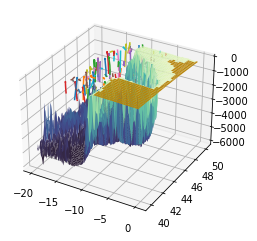

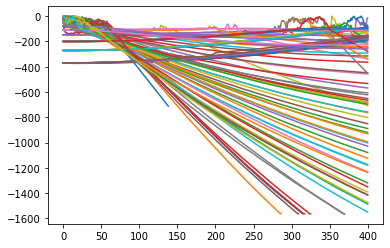

In [31]:
import cmocean
from tools import NEMO_select_section
import matplotlib.pyplot as plt
if os.environ['USER'] == 'kaandorp': # desktop
    dir_data = '/Volumes/externe_SSD/kaandorp/Data/'
elif os.environ['USER'] == 'kaand004': #gemini
    dir_data = '/storage/shared/oceanparcels/'


cmap = cmocean.cm.deep_r
newcmap = cmocean.tools.crop_by_percent(cmap, 5, which='max')
newcmap.set_over(color='darkgoldenrod')
extent = (-20,00,40,50)
extent_depth = (0,np.inf)

data_t1 = xr.open_dataset(os.path.join(dir_data, 'output_data/data_Mikael/00_run_files/output_MOi_h4_uniform_3D_8839_2019-01-05T12:00:00_4days_MixingTrue_FoulingTrue_nbTrue_l0.001000_testTrue_chunking0.nc') )

selection = (data_t1['lon'][:,0] > extent[0]) & (data_t1['lon'][:,0] < extent[1]) &\
    (data_t1['lat'][:,0] > extent[2]) & (data_t1['lat'][:,0] < extent[3]) &\
        (data_t1['z'][:,0] > extent_depth[0]) & (data_t1['z'][:,0] < extent_depth[1])
    
i_select = np.where(selection)[0]
i_rnd_select = np.random.choice(i_select, 100)


data_bathymetry = xr.open_dataset(os.path.join(dir_data, 'input_data/MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc') )
bathymetry = data_bathymetry['Bathymetry']


X,Y,Z = NEMO_select_section(extent,data_bathymetry['nav_lon'],data_bathymetry['nav_lat'],bathymetry)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,-Z,cmap=newcmap,vmax=-0.1,zorder=0)

fig2,ax2 = plt.subplots(1)

for i1 in i_rnd_select:
    ax.plot(data_t1['lon'][i1,:],data_t1['lat'][i1,:],-data_t1['z'][i1,:])
    ax2.plot(-data_t1['z'][i1,:],'-')
    
# ax2.set_ylim((-100,0))
# ax2.set_xlim(0,50)

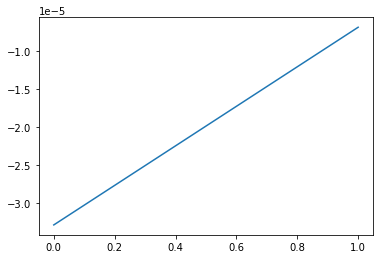

In [30]:
plt.figure()
plt.plot(data_t1['v_s'][i1,0:10])

<xarray.DataArray 'v_s' ()>
array(0.00592739)


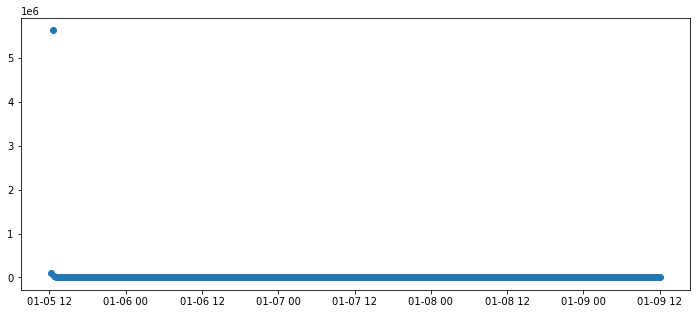

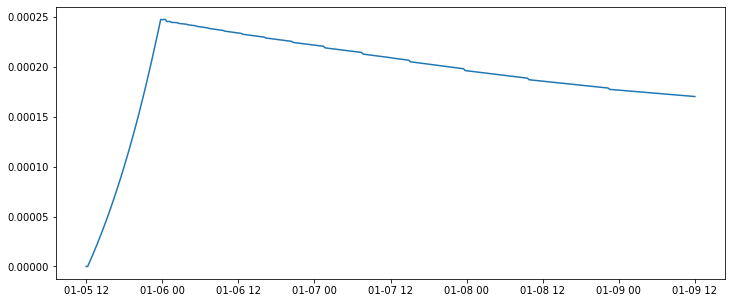

<Figure size 864x360 with 0 Axes>

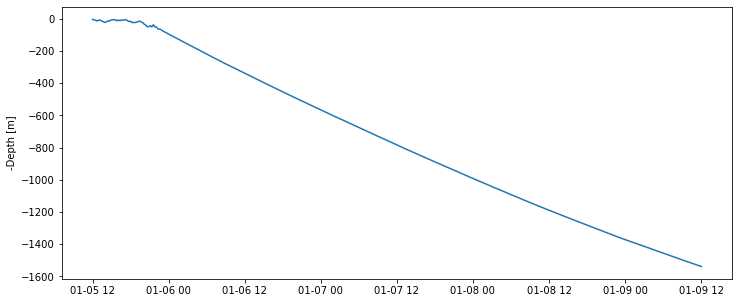

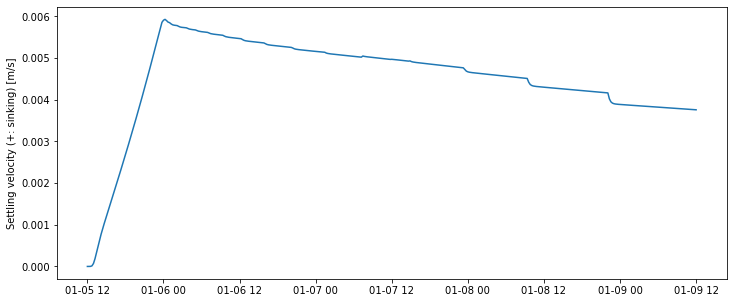

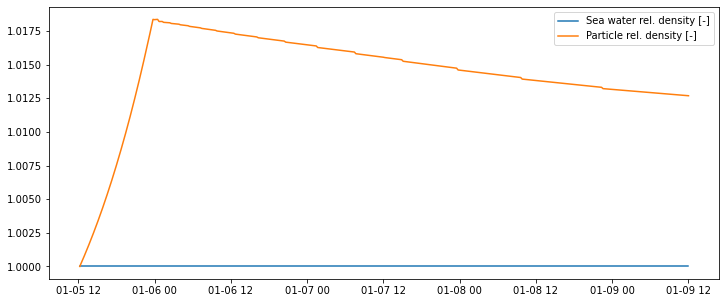

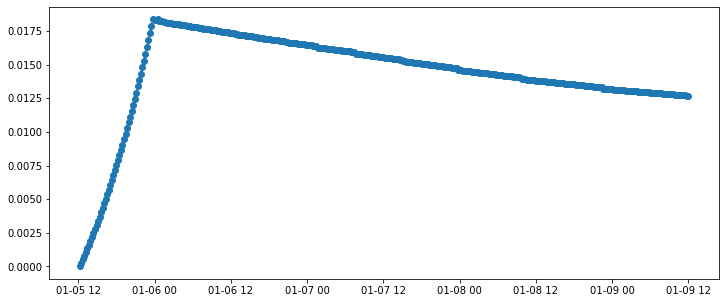

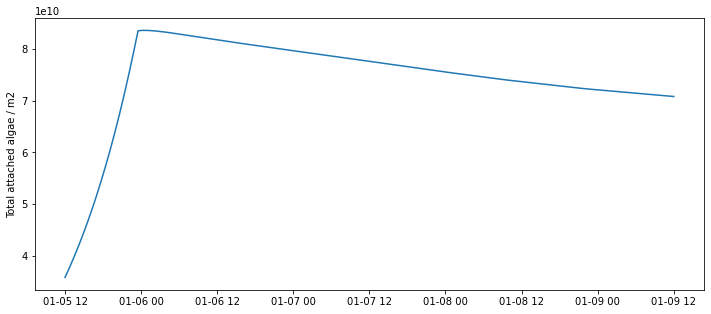

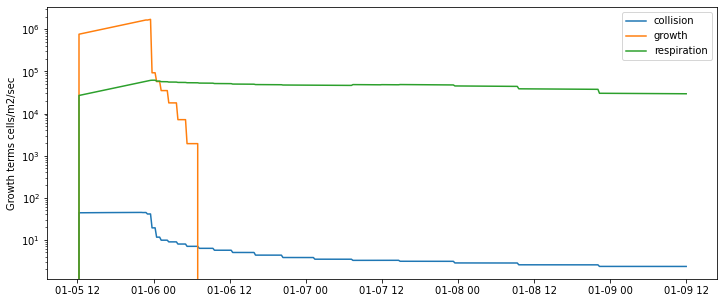

In [32]:
data_t1['s_a_growth'][i1,:]

i1 = 1
print(data_t1['v_s'][i1,:].max())
plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,1:],data_t1['s_cd'][i1,1:],'o')
plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][100,:],data_t1['s_RHS'][i1,:])
plt.figure(figsize=(12,5))
# plt.plot(data_t1['time'][100,:],data_t1['s_wstar'][i1,:])


plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,:],-data_t1['z'][i1,:])
plt.ylabel('-Depth [m]')

plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,:],data_t1['v_s'][i1,:])
plt.ylabel('Settling velocity (+: sinking) [m/s]')

plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,1:],data_t1['sw_density'][i1,1:]/data_t1['sw_density'][i1,1:],label='Sea water rel. density [-]')
plt.plot(data_t1['time'][i1,1:],data_t1['s_rho_total'][i1,1:]/data_t1['sw_density'][i1,1:],label='Particle rel. density [-]')
plt.legend()

plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,1:],data_t1['s_delta_rho'][i1,1:],'o-',label='parcels d_rho [-]')



plt.figure(figsize=(12,5))
plt.plot(data_t1['time'][i1,:],data_t1['a'][i1,:])
plt.ylabel('Total attached algae / m2')

plt.figure(figsize=(12,5))
plt.semilogy(data_t1['time'][i1,:],data_t1['s_a_coll'][i1,:],label='collision')
plt.semilogy(data_t1['time'][i1,:],data_t1['s_a_growth'][i1,:],label='growth')
plt.semilogy(data_t1['time'][i1,:],data_t1['s_a_resp'][i1,:],label='respiration')
plt.ylabel('Growth terms cells/m2/sec')
plt.legend()

In [ ]:
# data = xr.open_dataset(kzfiles[0])
# import matplotlib.pyplot as plt

# data['votkeavt'].shape

# # plt.figure()
# # plt.pcolormesh(data['votkeavt'][10,:,:])
# # plt.colorbar()

# # plt.figure()
# # plt.pcolormesh(data['votkeavt'][10,:,:]==0)
# # plt.colorbar()

# mask = data['votkeavt'][0,:,:]==0
# data['votkeavt'][0,:,:].min()

# fieldset.mixing_kz.show(vmin=-0.0001,vmax=0.0001)

# for i1 in range(30):
#     data = xr.open_dataset(kzfiles[i1])
#     extent = (-20,00,40,50)
#     X,Y,KZ_plot = NEMO_select_section(extent,data['votkeavt']['nav_lon'],data['votkeavt']['nav_lat'],data['votkeavt'][0,:,:])

#     plt.figure()
#     plt.pcolormesh(X,Y,KZ_plot)
#     plt.colorbar()

In [ ]:

data_xarray = xr.open_dataset(nc_path+nc_name)
outputdt = delta(hours=24)
show_time = np.arange(0,(
    
    (np.nanmax(data_xarray['time'].values)+np.timedelta64(outputdt))-np.nanmin(data_xarray['time'].values)),
outputdt) # timerange starting at zero in nanoseconds
outputdt = delta(hours=24)
timerange = np.arange(np.nanmin(data_xarray['time'].values),
np.nanmax(data_xarray['time'].values)+np.timedelta64(outputdt),
outputdt) # timerange in nanosecondsfig = plt.figure()
time_id = np.where(data_xarray['time'] == timerange[0])scatter = ax.scatter(data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id],
marker='+', color='darkblue', s=100)t = str(show_time[0].astype('timedelta64[M]'))
title = ax.set_title('Particles at t = '+t, fontsize=26)def animate(fn):
t=str(timerange[fn])[:10]
title.set_text('Particles at t = '+t)
time_id = np.where(data_xarray['time'] == timerange[fn])
scatter.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
anim = FuncAnimation(fig, animate, frames = len(timerange), interval=60)
plt.rcParams['animation.embed_limit'] = 2**128HTML(anim.to_jshtml())```

